## **0. Download dataset**
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [ ]:
# https://drive.google.com/file/d/1dboO_9Vw-Hj-QA5ySyEqsa7WMwVUYSiD/view?usp=drive_link
!gdown --id 1dboO_9Vw-Hj-QA5ySyEqsa7WMwVUYSiD

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1dboO_9Vw-Hj-QA5ySyEqsa7WMwVUYSiD
From (redirected): https://drive.google.com/uc?id=1dboO_9Vw-Hj-QA5ySyEqsa7WMwVUYSiD&confirm=t&uuid=401d3a28-55bd-44f3-b6aa-813a14c2b5ba
To: /content/daquar_vqa.zip
100% 431M/431M [00:04<00:00, 103MB/s] 


In [ ]:
!unzip -q daquar_vqa.zip

## **1. Import libraries**

In [ ]:
!pip install timm==0.8.17.dev0
!pip install torchtext==0.15.1
!pip install torchvision==0.16.0
!pip install torchaudio==2.1.0
!pip install torch==2.1.0
!pip install transformers==4.27.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.3 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.12
    Uninstalling timm-1.0.12:
      Successfully uninstalled timm-1.0.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.4 

In [ ]:
import torch
import torch.nn as nn
import torchtext
import os
import random
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt

from PIL import Image
from random import randint
from torchvision import transforms
from torch.optim.lr_scheduler import LambdaLR
from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## **2. Read dataset**



In [ ]:
def read_qa_csv(qa_csv_path, img_dir):
    df = pd.read_csv(qa_csv_path)
    df = df.dropna()

    items = []
    for idx, row in df.iterrows():
        img_path = os.path.join(img_dir, row['image_id'] + '.png')
        question = row['question']
        answers = row['answer']

        if os.path.exists(img_path):
            item = {
                'img_path': img_path,
                'question': question,
                'answer': answers
            }
            items.append(item)

    return items

In [ ]:
data_dir = 'dataset'
img_dir = os.path.join(data_dir, 'images')
train_qa_csv_path = os.path.join(data_dir, 'data_train.csv')
test_qa_csv_path = os.path.join(data_dir, 'data_eval.csv')

train_data = read_qa_csv(train_qa_csv_path, img_dir)
test_data = read_qa_csv(test_qa_csv_path, img_dir)

## **3. Train/val/test split**

In [ ]:
val_size = 0.3
train_data, val_data = train_test_split(train_data,
                                        test_size=val_size,
                                        shuffle=True,
                                        random_state=seed)

## **4. Data Preprocessing**

In [ ]:
eng = spacy.load("en_core_web_sm")

def get_tokens(data_iter):
    for sample in data_iter:
        question = sample['question']

        yield [token.text for token in eng.tokenizer(question)]

vocab = build_vocab_from_iterator(
    get_tokens(train_data),
    min_freq=2,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab.set_default_index(vocab['<unk>'])

In [ ]:
len(vocab)

568

In [ ]:
def tokenize(question, max_seq_len):
    tokens = [token.text for token in eng.tokenizer(question)]
    sequence = [vocab[token] for token in tokens]
    if len(sequence) < max_seq_len:
        sequence += [vocab['<pad>']] * (max_seq_len - len(sequence))
    else:
        sequence = sequence[:max_seq_len]

    return sequence

def detokenize(tokens):
    reverse_vocab = vocab.get_itos()

    tokens = [reverse_vocab[token_id] for token_id in tokens]

    reconstructed_string = " ".join(tokens)

    return reconstructed_string

In [ ]:
example_question = "is this a picture of a table?"
max_seq_len = 30

tokens = tokenize(example_question, max_seq_len)
detokenized_question = detokenize(tokens)
print(f"Tokenized question: {tokens}")
print(f"Detokenized question: {detokenized_question}")

Tokenized question: [6, 92, 271, 53, 8, 271, 13, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Detokenized question: is this a picture of a table <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [ ]:
answer_space_path = os.path.join(data_dir,
                                 'answer_space.txt')
with open(answer_space_path, 'r') as f:
    answer_space = f.read().split('\n')
label2idx = {label: idx for idx, label in enumerate(answer_space)}
idx2label = {idx: label for idx, label in enumerate(answer_space)}
n_classes = len(answer_space)

print(f'Number of classes: {n_classes}')

Number of classes: 582


## **5. Create Pytorch dataset**

In [ ]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        label2idx,
        max_seq_len=20,
        transform=None,
    ):
        self.transform = transform
        self.data = data
        self.max_seq_len = max_seq_len
        self.label2idx = label2idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]['img_path']
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        question = self.data[idx]['question']
        question = tokenize(question, self.max_seq_len)
        question = torch.tensor(question, dtype=torch.long)

        label = self.data[idx]['answer']
        label = label.split(', ')[0]
        label = label2idx[label]
        label = torch.tensor(label, dtype=torch.long)

        return img, question, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_visualize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
train_dataset = VQADataset(
    train_data,
    label2idx=label2idx,
    transform=transform
)
val_dataset = VQADataset(
    val_data,
    label2idx=label2idx,
    transform=transform
)
test_dataset = VQADataset(
    test_data,
    label2idx=label2idx,
    transform=transform
)
test_dataset_visualize = VQADataset(
    test_data,
    label2idx=label2idx,
    transform=transform_visualize
)

In [ ]:
train_batch_size = 128
test_batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader_visualize = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

Question: what is on the right side of the toy <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Ground Truth Ids: 483
Ground Truth: table


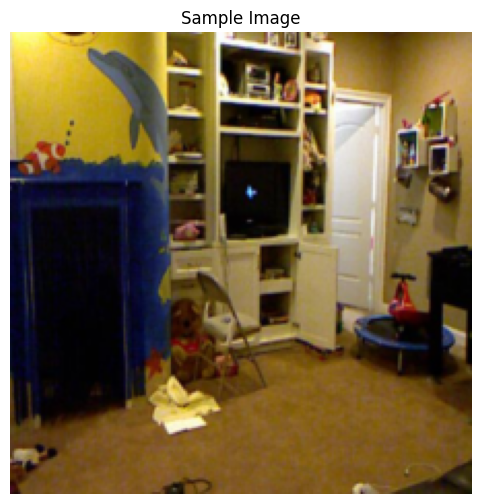

In [ ]:
sample_idx = 100
sample = test_dataset_visualize[sample_idx]
image, question, label = sample

plt.figure(figsize=(6, 6))
plt.imshow(image.permute(1, 2, 0).numpy())  # Convert to HWC format for plotting
plt.axis('off')
plt.title("Sample Image")

print(f"Question: {detokenize(question)}")
print(f"Ground Truth Ids: {label}")
print(f"Ground Truth: {idx2label[label.item()]}")

plt.show()

## **6. Load Teacher Model**

Modified a bit

In [ ]:
class TeacherVQAModel(nn.Module):
    def __init__(
        self,
        n_classes,
        img_model_name='resnet18',
        embeddding_dim=32,
        n_layers=2,
        hidden_size=64,
        drop_p=0.0,
        proj_dim=32,
        bidirect=False,
    ):
        super(TeacherVQAModel, self).__init__()
        # Image encoder
        self.image_encoder = timm.create_model(
            img_model_name,
            pretrained=True,
            num_classes=hidden_size
        )

        # Text embedding and LSTM
        self.embedding = nn.Embedding(len(vocab), embeddding_dim)
        self.lstm = nn.LSTM(
            input_size=embeddding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=bidirect,
            dropout=drop_p
        )

        # Projection head
        # hidden_size = 256
        # n_layers = 2
        # embeddding_dim = 128
        self.MLP = nn.Sequential(
            nn.Linear(hidden_size + hidden_size * 2, hidden_size + hidden_size),  # Index 0
            nn.ReLU(),  # Index 1
            nn.Dropout(drop_p),  # Index 2

            nn.Linear(hidden_size + hidden_size, proj_dim),  # Index 3
            nn.ReLU(),  # Index 4
            nn.Dropout(drop_p),  # Index 5

            nn.Linear(proj_dim, n_classes)  # Index 6
        )


    def forward(self, img, text, layer_index=3):
        # Image features
        img_features = self.image_encoder(img)  # (dim=256)

        # Text features
        text_emb = self.embedding(text)  # (dim=256)
        lstm_out, _ = self.lstm(text_emb)  # (dim=256)
        lstm_out = lstm_out[:, -1, :]  # Take the last hidden state  # (dim=256)

        # Concatenate image and text features
        x = torch.cat((img_features, lstm_out), dim=1)  # (dim=256+256=512)

        # Modified to take the 2nd Linear in the MLP as the teacher hidden_representation
        for idx, layer in enumerate(self.MLP):
          x = layer(x)
          if isinstance(layer, nn.Linear) and idx == layer_index:
              return x


In [ ]:
img_model_name = 'resnet50'  # 'resnet18'
hidden_size = 256  # 64
n_layers = 2
embeddding_dim = 128  # 32
drop_p = 0.15  # 0.0
proj_dim = 128  # 32
bidirect = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

teacher_model = TeacherVQAModel(
    n_classes=n_classes,
    img_model_name=img_model_name,
    embeddding_dim=embeddding_dim,
    n_layers=n_layers,
    hidden_size=hidden_size,
    drop_p=drop_p,
    proj_dim=proj_dim,
    bidirect=bidirect
).to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


In case you forgot saving or lost the teacher model, uncomment the below code blocks

In [ ]:
# https://drive.google.com/file/d/16vJlHXqg37-SEXwwTl0fn_1J5FnWj7-Y/view?usp=sharing
!gdown 16vJlHXqg37-SEXwwTl0fn_1J5FnWj7-Y

Downloading...
From (original): https://drive.google.com/uc?id=16vJlHXqg37-SEXwwTl0fn_1J5FnWj7-Y
From (redirected): https://drive.google.com/uc?id=16vJlHXqg37-SEXwwTl0fn_1J5FnWj7-Y&confirm=t&uuid=0b7a774e-fa61-41bb-9272-eb1d6ae27613
To: /content/teacher.pt
100% 108M/108M [00:01<00:00, 88.9MB/s]


Upload and load the teacher model

In [ ]:
teacher_model.load_state_dict(torch.load('/content/teacher.pt'))

<All keys matched successfully>

In [ ]:
images, questions, labels = next(iter(train_loader))
teacher_model.eval()
with torch.no_grad():
    images = images.to(device)
    questions = questions.to(device)
    output = teacher_model(images, questions)
    print(output.shape)

torch.Size([128, 128])


## **7. Create KD Student Model**

In [ ]:
import torch
import torch.nn as nn
import timm

class StudentVQAModel(nn.Module):
    def __init__(
        self,
        n_classes,
        img_model_name='resnet18',
        embeddding_dim=32,
        n_layers=2,
        hidden_size=64,
        drop_p=0.0,
        proj_dim=32,
        bidirect=False,
    ):
        super(StudentVQAModel, self).__init__()
        # Image encoder
        self.image_encoder = timm.create_model(
            img_model_name,
            pretrained=True,
            num_classes=hidden_size
        )

        # Text embedding and LSTM
        self.embedding = nn.Embedding(len(vocab), embeddding_dim)
        self.lstm = nn.LSTM(
            input_size=embeddding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=bidirect,
            dropout=drop_p
        )

        # Projection head
        self.MLP = nn.Sequential(
            nn.Linear(hidden_size + hidden_size, proj_dim),
            nn.ReLU(),
            nn.Linear(proj_dim, n_classes)
        )


    def forward(self, img, text):
        # Image features
        img_features = self.image_encoder(img)  # (dim=64)

        # Text features
        text_emb = self.embedding(text)  # (dim=64)
        lstm_out, _ = self.lstm(text_emb)  # (dim=64)
        lstm_out = lstm_out[:, -1, :]  # Take the last hidden state  # (dim=64)

        # Concatenate image and text features
        x = torch.cat((img_features, lstm_out), dim=1)  # (dim=64+64=128)

        # Modified to take student hidden_representation
        hidden_representation = x

        x = self.MLP(x)

        return x, hidden_representation


In [ ]:
img_model_name = 'resnet18'
hidden_size = 64
n_layers = 2
embeddding_dim = 32
drop_p = 0.0
proj_dim = 32
bidirect = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'

student_model = StudentVQAModel(
    n_classes=n_classes,
    img_model_name=img_model_name,
    embeddding_dim=embeddding_dim,
    n_layers=n_layers,
    hidden_size=hidden_size,
    drop_p=drop_p,
    proj_dim=proj_dim,
    bidirect=bidirect
).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
images, questions, labels = next(iter(train_loader))
student_model.eval()
with torch.no_grad():
    images = images.to(device)
    questions = questions.to(device)
    output, hidden_representation = student_model(images, questions)
    print(output.shape, hidden_representation.shape)

torch.Size([128, 582]) torch.Size([128, 128])


## **8. KD Training**

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, questions, labels in dataloader:
            images, questions, labels = images.to(device), questions.to(device), labels.to(device)

            outputs, _ = model(images, questions)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs.data, 1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_correct / total_samples

    return avg_loss, avg_acc


In [ ]:
def train_cosine_loss(teacher, student, hidden_rep_loss_weight, ce_loss_weight, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs, patience):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    patience_counter = 0

    cosine_loss = nn.CosineEmbeddingLoss()
    teacher.eval()

    for epoch in range(epochs):
        student.train()
        batch_train_losses = []
        correct_train_preds = 0
        total_train_samples = 0

        for images, questions, labels in train_loader:
            images, questions, labels = images.to(device), questions.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                teacher_hidden_representation = teacher(images, questions)

            student_logits, student_hidden_representation = student(images, questions)

            hidden_rep_loss = cosine_loss(student_hidden_representation, teacher_hidden_representation, target=torch.ones(labels.size(0)).to(device))

            label_loss = criterion(student_logits, labels)

            loss = hidden_rep_loss_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

            _, preds = torch.max(student_logits.data, 1)
            correct_train_preds += (preds == labels).sum().item()
            total_train_samples += labels.size(0)

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)
        train_acc = correct_train_preds / total_train_samples
        train_accuracies.append(train_acc)

        val_loss, val_acc = evaluate(student, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        scheduler.step()

        # Print epoch summary
        print(f"EPOCH {epoch + 1}:\tTrain Loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}\tVal Loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}")

        # Check early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies


In [ ]:
def lr_lambda(epoch, warmup_epochs=5, total_epochs=30, init_scale=0.1, min_scale=0.0):
    scale_range = 1.0 - min_scale

    if epoch < warmup_epochs:
        warmup_factor = epoch / warmup_epochs
        return init_scale + (1.0 - init_scale) * warmup_factor

    decay_factor = (total_epochs - epoch) / (total_epochs - warmup_epochs)
    return min_scale + scale_range * max(0.0, decay_factor)

lr = 1e-3
epochs = 30
patience = 3

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    student_model.parameters(),
    lr=lr
)

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

In [ ]:
for epoch in range(epochs):
    print(f'Epoch {epoch}, LR: {lr * lr_lambda(epoch):.6f}')

Epoch 0, LR: 0.000100
Epoch 1, LR: 0.000280
Epoch 2, LR: 0.000460
Epoch 3, LR: 0.000640
Epoch 4, LR: 0.000820
Epoch 5, LR: 0.001000
Epoch 6, LR: 0.000960
Epoch 7, LR: 0.000920
Epoch 8, LR: 0.000880
Epoch 9, LR: 0.000840
Epoch 10, LR: 0.000800
Epoch 11, LR: 0.000760
Epoch 12, LR: 0.000720
Epoch 13, LR: 0.000680
Epoch 14, LR: 0.000640
Epoch 15, LR: 0.000600
Epoch 16, LR: 0.000560
Epoch 17, LR: 0.000520
Epoch 18, LR: 0.000480
Epoch 19, LR: 0.000440
Epoch 20, LR: 0.000400
Epoch 21, LR: 0.000360
Epoch 22, LR: 0.000320
Epoch 23, LR: 0.000280
Epoch 24, LR: 0.000240
Epoch 25, LR: 0.000200
Epoch 26, LR: 0.000160
Epoch 27, LR: 0.000120
Epoch 28, LR: 0.000080
Epoch 29, LR: 0.000040


In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = train_cosine_loss(
    teacher_model,
    student_model,
    0.25,
    0.75,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs,
    patience
)

EPOCH 1:	Train Loss: 4.9110	Train Acc: 0.0139	Val Loss: 6.2599	Val Acc: 0.0241
EPOCH 2:	Train Loss: 4.5919	Train Acc: 0.0274	Val Loss: 5.6742	Val Acc: 0.0257
EPOCH 3:	Train Loss: 3.9264	Train Acc: 0.0567	Val Loss: 5.0586	Val Acc: 0.0334
EPOCH 4:	Train Loss: 3.6130	Train Acc: 0.0799	Val Loss: 5.1264	Val Acc: 0.0334
EPOCH 5:	Train Loss: 3.4900	Train Acc: 0.0915	Val Loss: 4.9949	Val Acc: 0.0461
EPOCH 6:	Train Loss: 3.3334	Train Acc: 0.1239	Val Loss: 4.8478	Val Acc: 0.0902
EPOCH 7:	Train Loss: 3.0920	Train Acc: 0.1630	Val Loss: 4.7769	Val Acc: 0.0875
EPOCH 8:	Train Loss: 2.8981	Train Acc: 0.1826	Val Loss: 4.7613	Val Acc: 0.0905
EPOCH 9:	Train Loss: 2.7430	Train Acc: 0.2015	Val Loss: 4.7570	Val Acc: 0.0922
EPOCH 10:	Train Loss: 2.6216	Train Acc: 0.2199	Val Loss: 4.8983	Val Acc: 0.0875
EPOCH 11:	Train Loss: 2.5003	Train Acc: 0.2298	Val Loss: 5.0426	Val Acc: 0.0895
EPOCH 12:	Train Loss: 2.3950	Train Acc: 0.2386	Val Loss: 5.1291	Val Acc: 0.0979
Early stopping triggered after 12 epochs.


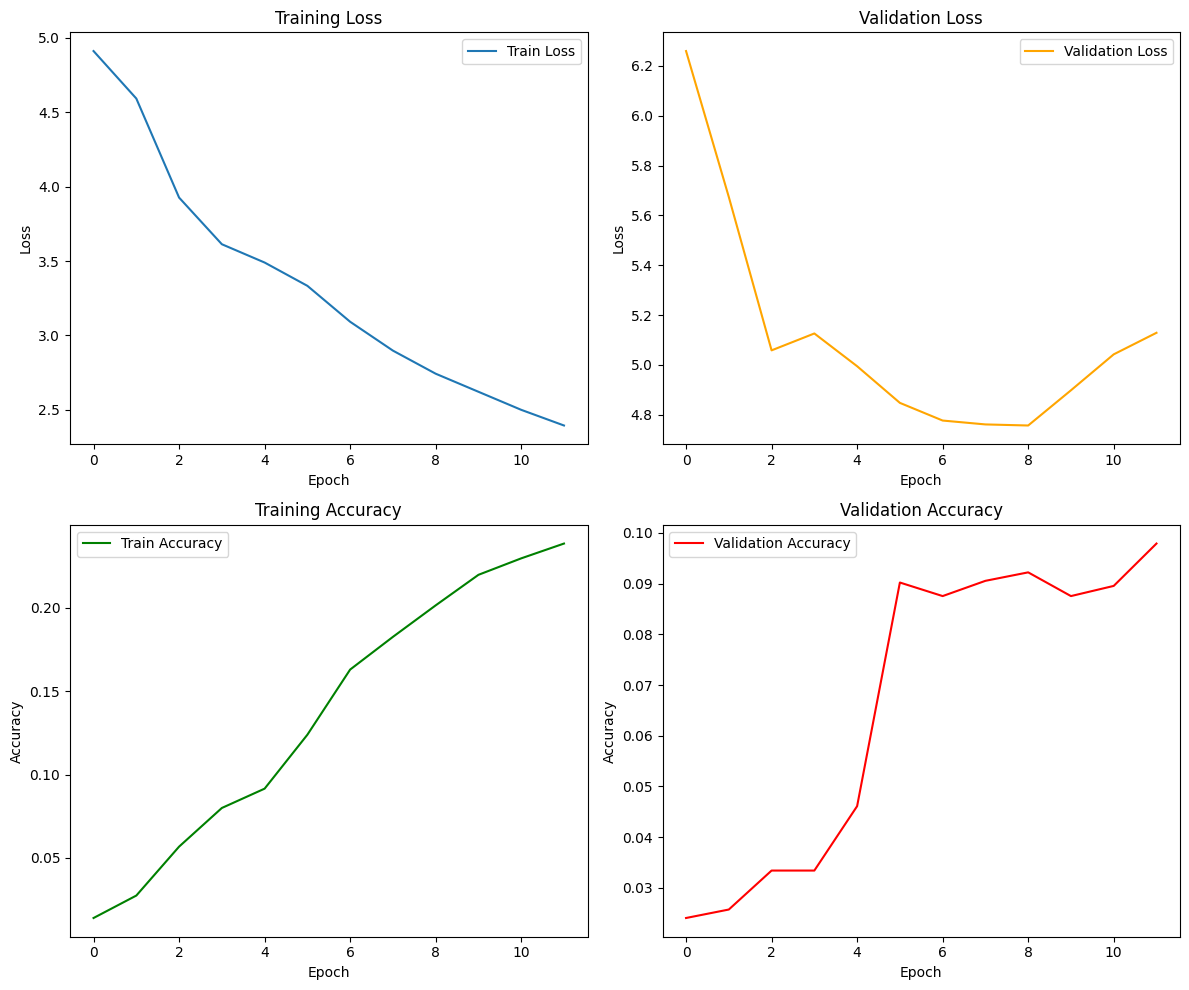

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot Training Loss
ax[0, 0].plot(train_losses, label='Train Loss')
ax[0, 0].set_title('Training Loss')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].legend()

# Plot Validation Loss
ax[0, 1].plot(val_losses, label='Validation Loss', color='orange')
ax[0, 1].set_title('Validation Loss')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Loss')
ax[0, 1].legend()

# Plot Training Accuracy
ax[1, 0].plot(train_accuracies, label='Train Accuracy', color='green')
ax[1, 0].set_title('Training Accuracy')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('Accuracy')
ax[1, 0].legend()

# Plot Validation Accuracy
ax[1, 1].plot(val_accuracies, label='Validation Accuracy', color='red')
ax[1, 1].set_title('Validation Accuracy')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('Accuracy')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

## **9. Evaluation**

In [ ]:
test_loss, test_acc = evaluate(student_model, test_loader, criterion, device)

print('Evaluation on test dataset')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

Evaluation on test dataset
Test loss:  5.083681249618531
Test accuracy:  0.10144346431435446


## **10. Inference**

In [ ]:
def demo(amount):
  student_model.eval()

  for i in range(amount):
    sample_idx = randint(0, n_classes)
    image, question, label = test_dataset[sample_idx]
    image_viz, _, _ = test_dataset_visualize[sample_idx]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.unsqueeze(0).to(device)
    question = question.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs, _ = student_model(image, question)
        _, preds = torch.max(outputs.data, 1)

    original_question = detokenize(question.squeeze().cpu().numpy())
    true_labels = [idx2label[label.item()]]
    predicted_labels = [idx2label[preds.item()]]

    plt.figure(figsize=(6, 6))
    plt.imshow(np.clip(image_viz.squeeze().permute(1, 2, 0).cpu().numpy(), 0, 1))
    plt.axis('off')
    plt.title("Image from Test Dataset")

    print(f"Question: {original_question}")
    print(f"Ground Truth Labels: {true_labels}")
    print(f"Predicted Labels: {predicted_labels}")

    plt.show()

Question: what is on the right side of the lamp <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Ground Truth Labels: ['tissue_box']
Predicted Labels: ['pillow']


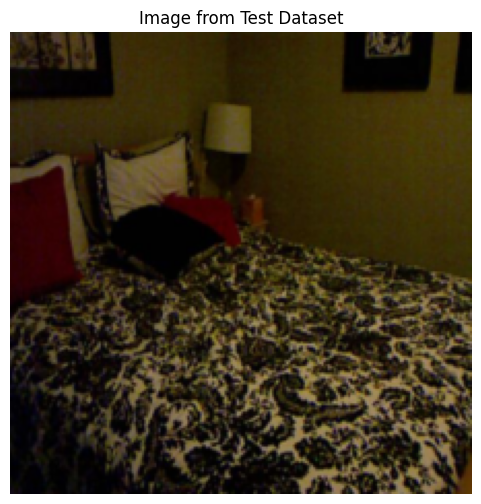

Question: what is below the table <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Ground Truth Labels: ['box']
Predicted Labels: ['jacket']


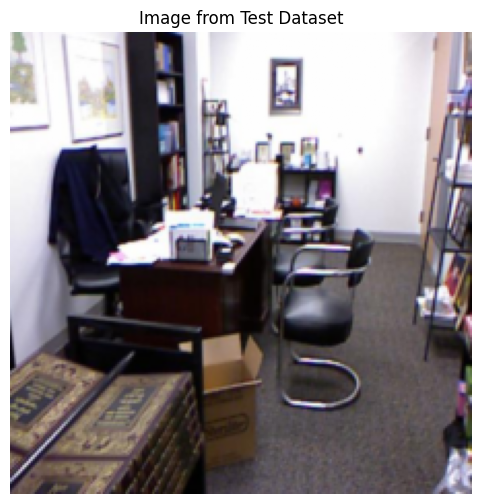

Question: what is on the left side of the cables <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Ground Truth Labels: ['clothes']
Predicted Labels: ['garbage_bin']


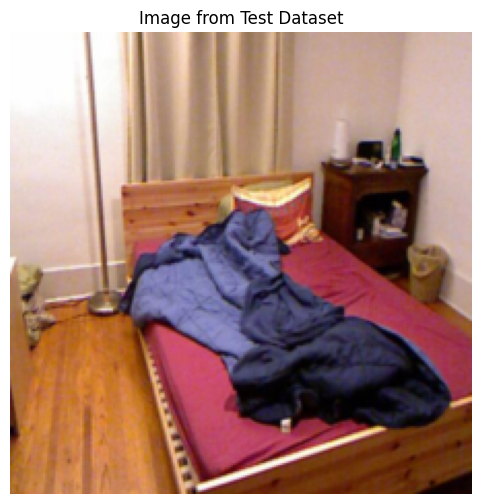

In [ ]:
demo(3)

## **11. Save and Download the model**

In [ ]:
save_path = '/content/cosine_student.pt'
torch.save(student_model.state_dict(), save_path)